<a href="https://colab.research.google.com/github/alexantaki16/covid/blob/master/Code/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can we diagnosis Covid, Pneumonia, or Normal Chest X Rays with computer vision?

I am going to use TensorFlow for this project.  

## What will this notebook cover?
I am going to go show you:
* EDA
* Prepreocessing
* Model Building
* Model Evaluation
* Model Enhancement
* Plotting our loss curves

## Get the data for your own models!
The data is from Kaggle.  Click [here](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) to view it!

Are you ready?  Let's go.

#1 Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam
from keras.models import Sequential

import math

import os
from google.colab import drive

!pip install split_folders
import splitfolders

#2 Import the data

> Note: The data will be redownloaded every time we run this.  It is automatic, however, it is good to know :).

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

#This will connect to our kaggle.json document
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/"

#This will download the dataset directly into the colab 
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

#Unzip the file
!unzip covid19-radiography-database.zip

#Navigate to the directory the data is in
os.chdir("/content/COVID-19_Radiography_Dataset/")

# 3.1 Explore the data

* What type of data are we dealing with?
  - Images
* What are the shapes?
  - 229, 229
* Are the other ways for us to learn about the data?
  - Metadata files
* Are there any imbalances?
  - Yes

In [3]:
#Import all of the metadata files to view
covid_metadata = pd.read_excel("COVID.metadata.xlsx")
normal_metadata = pd.read_excel("Normal.metadata.xlsx")
viral_pneumonia_metadata = pd.read_excel("Viral Pneumonia.metadata.xlsx")

#What can we learn before we plot?
* We can see the first few rows of data to be certain our data is in.
  - `head()`
* We can see the last few rows to get a sense of the size of the data
  - `tail()`
* We can see the description of the dataframes too.
  - `describe()`
* We can see the info of the dataframe.
  - `info()`
* We can see the column names of the dataframe.
  - `.columns`
* We can see the data types of the columns
  - `dtypes()`
* We can see if we have missing values
  - `isna()`
* We can see the shape
  - `.shape`

Let's make a helper function so reduce our code

In [4]:
def separate_learning_functions():
  """
  Summary: This provides clean spacing to help separate the pandas functions

  Descrtiption:  After this cell, we have a "learn_about_covid_metadata()" function.
  I am using this function to reduce the amount of code.  Modularizing code is a great skill.

  Params: None

  Return: None
  """
  print()
  print("=" * 100)
  print()
  print("#" * 100)

In [5]:
def get_df_name(dataframe):
    """
    Summary:  This is a function from Stack Overflow. https://stackoverflow.com/questions/31727333/get-the-name-of-a-pandas-dataframe

    Description:  Thank you for sharing this function

    Parameters: A dataframe

    Return: The dataframe name
    """
    name =[x for x in globals() if globals()[x] is dataframe][0]
    return name

In [6]:
def learn_about_dataframes(dataframe):
  """
  Summary:  This is the function that allows the viewer to see a quick walkthrough of the data

  Description:  We have a lot of useful Pandas functions.  These are some of the few that are used almost all the time.
  They are all in one area with this function.

  Parameters: dataframe

  Return: None
  """
  dataframe_name = get_df_name(dataframe)

  print("#" * 50, dataframe_name.upper(), "#" * 50)
  print("+" * 45, "Head Method", "+" * 45)
  print(dataframe.head())
  print("+" * 40, "End Head Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Tail Method", "+" * 40)
  print(dataframe.tail())
  print("+" * 40, "End Tail Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Describe Method", "+" * 40)
  print(dataframe.describe())
  print("+" * 40, "End Describe Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Info Method", "+" * 40)
  print(dataframe.info())
  print("+" * 40, "End Info Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Columns Method", "+" * 40)
  print(dataframe.columns)
  print("+" * 40, "End Columns Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "isna Method", "+" * 40)
  print(dataframe.isna())
  print("+" * 40, "End isna Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Shape Method", "+" * 40)
  print(dataframe.shape)
  print("+" * 40, "Shape Method", "+" * 40)

  separate_learning_functions()

  print("#" * 40, "End", dataframe_name.upper(), "#" * 40)
  print("#" * 100)

In [7]:
learn_about_dataframes(covid_metadata)

################################################## COVID_METADATA ##################################################
+++++++++++++++++++++++++++++++++++++++++++++ Head Method +++++++++++++++++++++++++++++++++++++++++++++
  FILE NAME FORMAT     SIZE                                                URL
0   COVID-1    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
1   COVID-2    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
2   COVID-3    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
3   COVID-4    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
4   COVID-5    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
++++++++++++++++++++++++++++++++++++++++ End Head Method ++++++++++++++++++++++++++++++++++++++++


####################################################################################################
++++++++++++++++++++++++++++++++++++++++ Tail Method ++++++++++++++++++++++++++++++++++++++++
       FIL

#What is the Covid metadata learning function telling us?

- `head()`
  - The dataframe imported successfully.
  - It looks like we have 4 columns (file name, format, pixel density, and the url)
  - The pixels are 256 * 256
- `tail()`
  - There are 3615 rows
- `describe()`
  - There are 3615 counts of images which means every image is unique.  Sweet.
- `info()`
  - We can see the fours columns is correct
  - They are all objects but that is okay since we are using this to help us understand the data.  This is not going to be in the model section.
- `isna()`
  - We can see the False statements showing us there is no missing data.  This is only a snippet so do not assume that means everything is there.
- `shape`
  - The shape of the dataframe is 3615 x 4 which makes sense.  The top row is includes so it says there is one more row than I wrote here.  The 4 columns is confirmed yet again.

In [8]:
learn_about_dataframes(viral_pneumonia_metadata)

################################################## VIRAL_PNEUMONIA_METADATA ##################################################
+++++++++++++++++++++++++++++++++++++++++++++ Head Method +++++++++++++++++++++++++++++++++++++++++++++
           FILE NAME  ...                                                URL
0  Viral Pneumonia-1  ...  https://www.kaggle.com/paultimothymooney/chest...
1  Viral Pneumonia-2  ...  https://www.kaggle.com/paultimothymooney/chest...
2  Viral Pneumonia-3  ...  https://www.kaggle.com/paultimothymooney/chest...
3  Viral Pneumonia-4  ...  https://www.kaggle.com/paultimothymooney/chest...
4  Viral Pneumonia-5  ...  https://www.kaggle.com/paultimothymooney/chest...

[5 rows x 4 columns]
++++++++++++++++++++++++++++++++++++++++ End Head Method ++++++++++++++++++++++++++++++++++++++++


####################################################################################################
++++++++++++++++++++++++++++++++++++++++ Tail Method +++++++++++++++++++++++++++++++

#What is the Viral Pnemonia metadata learning telling us?

- `head()`
  - The dataframe imported successfully
  - There are four columns again.  They are file name, format (peg), pixel density, and url.
- `tail()`
  - We are handling 1344 rows of data.  That is a noticebale difference from the Covid one.  The previous one has 3616.  We have over 2.5x the amount.  Hmm.  Class imbalance magic will be helpful.  Maybe augment one dataset and not the other 🤔.
- `describe()`
  - There are 1345 unique columns 
- `info()`
  - This confirms the four columns and we are dealing with object since it is text but that is okay.
- `columns`
  - We can see the four columns.
- `isna()`
  - This tells us that there are no missing values.  It is not the whole dataset, be careful and do not assume that everything is good to go.
- `shape`
  - The shape is 1345, 4.  That confirms the 1345 rows from the tail and the four columns from info and columns

In [9]:
learn_about_dataframes(normal_metadata)

################################################## NORMAL_METADATA ##################################################
+++++++++++++++++++++++++++++++++++++++++++++ Head Method +++++++++++++++++++++++++++++++++++++++++++++
  FILE NAME FORMAT     SIZE                                                URL
0  NORMAL-1    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
1  NORMAL-2    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
2  NORMAL-3    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
3  NORMAL-4    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
4  NORMAL-5    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
++++++++++++++++++++++++++++++++++++++++ End Head Method ++++++++++++++++++++++++++++++++++++++++


####################################################################################################
++++++++++++++++++++++++++++++++++++++++ Tail Method ++++++++++++++++++++++++++++++++++++++++
         

#What is the Normal metadaa learning function telling us?

- `head()`
  - The dataframe import successfull
- `tail()`
  - We have 10191 rows
- `describe()`
  - We have all unique images
- `info()`
  - We know we have a full dataset with 10191 rows and 4 columns
- `columns`
  - There are definitely four columns only
- `isna()`
  - We can see everything is false which is good.  This does not mean everything is false.
- `shape`
  - This shape = 10192, 4.  This confirms the row / column count

# The Key Takeaway
- Covid = 3616 images
- Pneumonia = 1345 images
- Normal = 10191 images

This should be fixed.

#3.2 Explore random images

In [10]:
def view_random_image(target_dir, target_class):
  """
  This is from a course I am taking on Zero to Mastery.
  Here is a link: https://academy.zerotomastery.io/p/learn-tensorflow
  """
  #Setup target directory
  target_folder = target_dir + target_class

  #Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

In [ ]:
pathways = ["COVID", "Viral Pneumonia", "Normal"]
covid_path = "/content/COVID-19_Radiography_Dataset/" + pathways[0] 
viral_pneumonia_path = "/content/COVID-19_Radiography_Dataset/" + pathways[1]
normal_path = "/content/COVID-19_Radiography_Dataset/" + pathways[2]

def view_random_image():
  """
  Summary: View a random image from the datasets

  Description:  This is a random image from the three xrays

  Parameters: None

  Return: None
  """

  def randomize_file():
    """
    Description: Return the random choice from a directory
    """
    return random.choice(os.listdir(path))

  def print_random_filename(random_file):
    """
    Description: This will print the filename to make it readable
    """
    random_filename = random_file.split(".png")[0]
    print(random_filename)


  def covid_img():
    """
    This will grab a random covid image
    """
    random_file = random.choice(os.listdir(covid_path))

    covid_img = mpimg.imread("/content/COVID-19_Radiography_Dataset/COVID/" + random_file)
    plt.imshow(covid_img)
    plt.title(random_file)
    print("Image shape: ", covid_img.shape)

  def pneumonia_img():
    """
    This will grab a random pneumonia image
    """
    random_file = random.choice(os.listdir(viral_pneumonia_path))

    plt.figure()
    viral_pneumonia_img = mpimg.imread("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/" + random_file)
    plt.imshow(viral_pneumonia_img)
    plt.title(random_file)
    print("Image shape: ", viral_pneumonia_img.shape)

  def normal_img():
    """
    This will grab a random normal image
    """
    random_file = random.choice(os.listdir(normal_path))
    plt.figure()
    normal_img = mpimg.imread("/content/COVID-19_Radiography_Dataset/Normal/" + random_file)
    plt.imshow(normal_img)
    plt.title(random_file)
    print("Image shape: ", normal_img.shape)

  covid_img()
  pneumonia_img()
  normal_img()

In [ ]:
view_random_image()

# Preprocessing

Let's make our ImageDataGenerators with no augmentation for now

In [13]:
os.chdir("/content/COVID-19_Radiography_Dataset/")

In [14]:
splitfolders.ratio("/content/COVID-19_Radiography_Dataset/", output="data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 21165 files [00:05, 3567.13 files/s]


In [15]:
#Remove unnecessary file
os.chdir("/content/COVID-19_Radiography_Dataset/data/train")
!rm -r "/content/COVID-19_Radiography_Dataset/data/train/Lung_Opacity"
!rm -r "/content/COVID-19_Radiography_Dataset/data/train/.ipynb_checkpoints"

os.chrdir("/content/COVID-19_Radiography_Dataset/data/val/")
!rm -r "/content/COVID-19_Radiography_Dataset/data/val/Lung_Opacity/"
!rm -r "/content/COVID-19_Radiography_Dataset/data/val/.ipynb_checkpoints/"

rm: cannot remove '/content/COVID-19_Radiography_Dataset/data/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/COVID-19_Radiography_Dataset/data/val/.ipynb_checkpoints/': No such file or directory


In [16]:
#Set up training directories
train_dir = "/content/COVID-19_Radiography_Dataset/data/train/"
test_dir = "/content/COVID-19_Radiography_Dataset/data/val/"

In [17]:
#Let's make the datagens
train_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [18]:
#Set up the train data
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (299, 299),
                                               class_mode = "categorical",
                                               batch_size = 32,
                                               shuffle = True)

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size = (299, 299),
                                              class_mode = "categorical",
                                              batch_size = 32,
                                              shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


# Models!

## Model 1 of 10

* This is the baseline.  Let's build it and then beat it with model 2!

In [19]:
#1 Build the baseline mode;

model_1 = Sequential([
  Conv2D(10, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

#2 Compile the model
model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ["accuracy"])

#3 Fit the model
history_1 = model_1.fit(train_data,
                        epochs = 30,
                        validation_data = test_data,
                        steps_per_epoch = math.ceil(len(train_data) / 32),
                        validation_steps = math.ceil(len(test_data) / 32))

Epoch 1/30
12/12 [==============================] - 22s 2s/step - loss: 0.9252 - accuracy: 0.7143 - val_loss: 0.8006 - val_accuracy: 0.6771
Epoch 2/30
12/12 [==============================] - 20s 2s/step - loss: 0.7840 - accuracy: 0.6674 - val_loss: 0.7860 - val_accuracy: 0.6250
Epoch 3/30
12/12 [==============================] - 21s 2s/step - loss: 0.6886 - accuracy: 0.7068 - val_loss: 0.6459 - val_accuracy: 0.6667
Epoch 4/30
12/12 [==============================] - 21s 2s/step - loss: 0.5617 - accuracy: 0.7438 - val_loss: 0.5389 - val_accuracy: 0.7708
Epoch 5/30
12/12 [==============================] - 20s 2s/step - loss: 0.4689 - accuracy: 0.7963 - val_loss: 0.4547 - val_accuracy: 0.7812
Epoch 6/30
12/12 [==============================] - 20s 2s/step - loss: 0.4542 - accuracy: 0.7779 - val_loss: 0.4881 - val_accuracy: 0.7500
Epoch 7/30
12/12 [==============================] - 20s 2s/step - loss: 0.5095 - accuracy: 0.7679 - val_loss: 0.5388 - val_accuracy: 0.7604
Epoch 8/30
12/12 [==

In [20]:
def plot_loss_curves(history):
  """
  Summary: This is from a class I am taking on Zero to Mastery.  Here is a link: https://academy.zerotomastery.io/p/learn-tensorflow

  Description: This can plot the loss curves of our model

  Parameters: history

  Returns: Separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

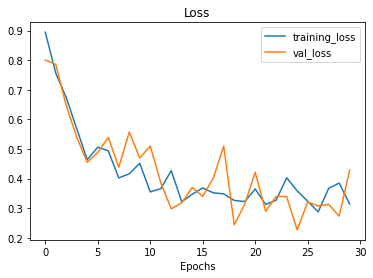

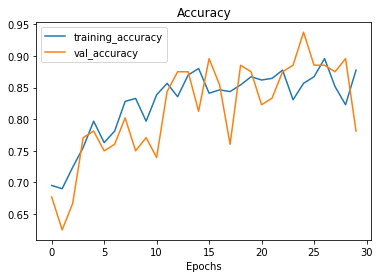

In [21]:
plot_loss_curves(history_1)

There it is.  Model 1 done.  That is the benchmark.  Let's zoom past it.

Our model is actually decent.  It is very jagged though.  Let's add data through data augmentation and keep everything else the same for this model

## Model 2 of 10
* How can we help this?
  - Data augmentation to the rescue?

In [22]:
#Set up datagen
train_datagen_2 = ImageDataGenerator(rescale = 1. / 255,
                                     rotation_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     fill_mode = "nearest")

test_datagen_2 = ImageDataGenerator(rescale = 1. / 255,
                                    rotation_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    fill_mode = "nearest")

In [23]:
#Set up train data
train_data_2 = train_datagen_2.flow_from_directory(train_dir,
                                                   target_size = (299, 299),
                                                   class_mode = "categorical",
                                                   batch_size = 32,
                                                   shuffle = True)

test_data_2 = test_datagen_2.flow_from_directory(test_dir,
                                                 target_size = (299, 299),
                                                 class_mode = "categorical",
                                                 batch_size = 32,
                                                 shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [24]:
#1. Build the model
model_2 = Sequential([
  Conv2D(10, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

#2. Compile the model
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ["accuracy"])

#3. Fit the model
history_2 = model_2.fit(train_data_2,
                        epochs = 30,
                        validation_data = test_data,
                        steps_per_epoch = math.ceil(len(train_data_2) / 32),
                        validation_steps = math.ceil(len(test_data_2) / 32))

Epoch 1/30
12/12 [==============================] - 28s 2s/step - loss: 0.9675 - accuracy: 0.5635 - val_loss: 0.7777 - val_accuracy: 0.7188
Epoch 2/30
12/12 [==============================] - 28s 2s/step - loss: 0.8337 - accuracy: 0.6675 - val_loss: 0.7969 - val_accuracy: 0.6146
Epoch 3/30
12/12 [==============================] - 28s 2s/step - loss: 0.7861 - accuracy: 0.6181 - val_loss: 0.5727 - val_accuracy: 0.8438
Epoch 4/30
12/12 [==============================] - 27s 2s/step - loss: 0.6820 - accuracy: 0.6860 - val_loss: 0.4652 - val_accuracy: 0.8333
Epoch 5/30
12/12 [==============================] - 28s 2s/step - loss: 0.6036 - accuracy: 0.7525 - val_loss: 0.5873 - val_accuracy: 0.6979
Epoch 6/30
12/12 [==============================] - 27s 2s/step - loss: 0.5755 - accuracy: 0.7260 - val_loss: 0.6287 - val_accuracy: 0.7292
Epoch 7/30
12/12 [==============================] - 28s 2s/step - loss: 0.6471 - accuracy: 0.7112 - val_loss: 0.6819 - val_accuracy: 0.6562
Epoch 8/30
12/12 [==

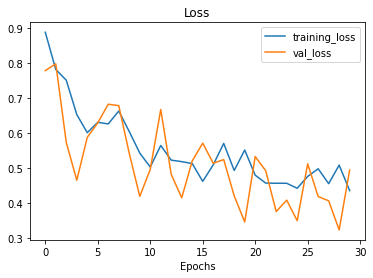

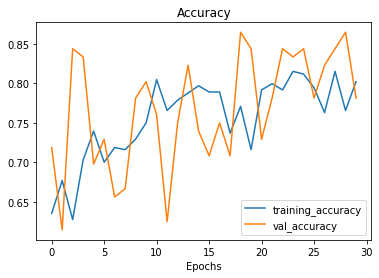

In [25]:
plot_loss_curves(history_2)

## Model 3 of 10
- Data Augmentation seems to have kept this the same.
- Let's go try a different archtiecture this time.

In [26]:
#Set up datagen
train_datagen_3 = ImageDataGenerator(rescale = 1. / 255,
                                     rotation_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     fill_mode = "nearest")

test_datagen_3 = ImageDataGenerator(rescale = 1. / 255,
                                    rotation_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    fill_mode = "nearest")

In [27]:
#Set up train data
train_data_3 = train_datagen_3.flow_from_directory(train_dir,
                                                   target_size = (299, 299),
                                                   class_mode = "categorical",
                                                   batch_size = 32,
                                                   shuffle = True)

test_data_3 = test_datagen_3.flow_from_directory(test_dir,
                                                 target_size = (299, 299),
                                                 class_mode = "categorical",
                                                 batch_size = 32,
                                                 shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [28]:
#1 Build the model
model_3 = Sequential([
  Conv2D(32, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

#2 Compile the model
model_3.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ["accuracy"])

#3 Fit the model
history_3 = model_3.fit(train_data_3,
                        epochs = 30,
                        validation_data = test_data_3,
                        steps_per_epoch = len(train_data_3) / 32,
                        validation_steps = len(test_data_3) / 32)

Epoch 1/30
11/11 [==============================] - 60s 5s/step - loss: 0.9277 - accuracy: 0.6588 - val_loss: 0.9266 - val_accuracy: 0.5938
Epoch 2/30
11/11 [==============================] - 54s 4s/step - loss: 0.8822 - accuracy: 0.6488 - val_loss: 0.7675 - val_accuracy: 0.7083
Epoch 3/30
11/11 [==============================] - 52s 4s/step - loss: 0.7990 - accuracy: 0.6956 - val_loss: 0.7389 - val_accuracy: 0.6875
Epoch 4/30
11/11 [==============================] - 53s 4s/step - loss: 0.8307 - accuracy: 0.6087 - val_loss: 0.8637 - val_accuracy: 0.6250
Epoch 5/30
11/11 [==============================] - 54s 5s/step - loss: 0.7864 - accuracy: 0.6731 - val_loss: 0.6577 - val_accuracy: 0.6667
Epoch 6/30
11/11 [==============================] - 53s 4s/step - loss: 0.6584 - accuracy: 0.6885 - val_loss: 0.5291 - val_accuracy: 0.7708
Epoch 7/30
11/11 [==============================] - 52s 4s/step - loss: 0.5818 - accuracy: 0.7126 - val_loss: 0.6703 - val_accuracy: 0.6875
Epoch 8/30
11/11 [==

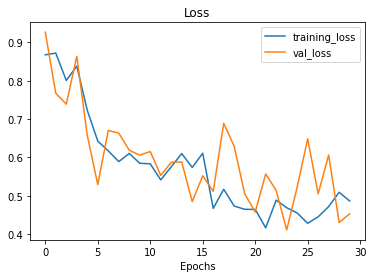

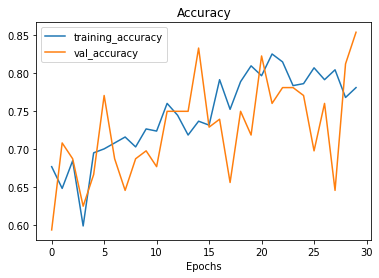

In [29]:
plot_loss_curves(history_3)

## Model 4 of 10


In [30]:
#Set up datagen
train_datagen_4 = ImageDataGenerator(rescale = 1 / 255.,
                                     width_shift_range = 0.2,
                                     rotation_range = 0.2,
                                     zoom_range = 0.2,
                                     shear_range = 0.2)

test_datagen_4 = ImageDataGenerator(rescale = 1 / 255.,
                                    width_shift_range = 0.2,
                                    rotation_range = 0.2,
                                    zoom_range = 0.2,
                                    shear_range = 0.2)

In [31]:
#Set up train data
train_data_4 = train_datagen_4.flow_from_directory(train_dir,
                                                   class_mode = "categorical",
                                                   target_size = (299, 299),
                                                   batch_size = 32,
                                                   shuffle = True)

test_data_4 = test_datagen_4.flow_from_directory(test_dir,
                                              class_mode = "categorical",
                                              target_size = (299, 299),
                                              batch_size = 32,
                                              shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [32]:
#1. Build the model
model_4 = tf.keras.models.Sequential([
  Conv2D(10, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(64, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

In [33]:
#2. Compile the model
model_4.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [34]:
#3. Fit
history_4 = model_4.fit(train_data_4,
                        epochs = 30,
                        steps_per_epoch = len(train_data_4) / 32,
                        validation_data = test_data_4,
                        validation_steps = len(test_data_4) / 32)

Epoch 1/30
11/11 [==============================] - 39s 3s/step - loss: 1.2868 - accuracy: 0.5521 - val_loss: 1.0774 - val_accuracy: 0.6562
Epoch 2/30
11/11 [==============================] - 37s 3s/step - loss: 0.8704 - accuracy: 0.6561 - val_loss: 0.7166 - val_accuracy: 0.7500
Epoch 3/30
11/11 [==============================] - 38s 3s/step - loss: 0.7054 - accuracy: 0.7155 - val_loss: 0.7021 - val_accuracy: 0.6146
Epoch 4/30
11/11 [==============================] - 38s 3s/step - loss: 0.7244 - accuracy: 0.6716 - val_loss: 0.7728 - val_accuracy: 0.6042
Epoch 5/30
11/11 [==============================] - 37s 3s/step - loss: 0.6432 - accuracy: 0.7288 - val_loss: 0.6259 - val_accuracy: 0.7396
Epoch 6/30
11/11 [==============================] - 38s 3s/step - loss: 0.6067 - accuracy: 0.7230 - val_loss: 0.6101 - val_accuracy: 0.7500
Epoch 7/30
11/11 [==============================] - 37s 3s/step - loss: 0.5785 - accuracy: 0.7243 - val_loss: 0.6569 - val_accuracy: 0.7083
Epoch 8/30
11/11 [==

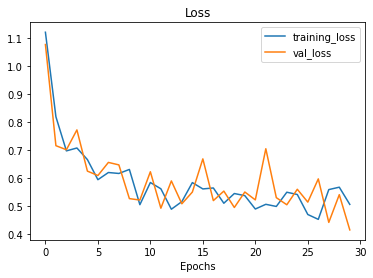

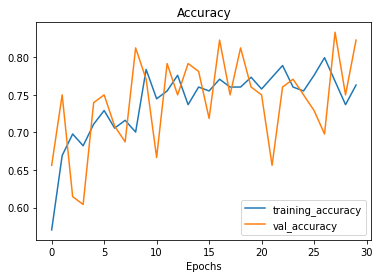

In [35]:
plot_loss_curves(history_4)

## Model 5 of 10

Efficient Net B0 Feature Extraction

In [36]:
#1. Set up train data
train_data_5 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = (224, 224))

test_data_5 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                     label_mode = "categorical",
                                                                     image_size = (224, 224))

Found 12121 files belonging to 3 classes.
Found 3032 files belonging to 3 classes.


In [37]:
#2 .Import base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

16711680/16705208 [==============================] - 0s 0us/step


In [38]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#3. Make the data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomZoom(0.2)                    
])

In [39]:
#4. Create the layers
inputs = layers.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation = "softmax")(x)

In [40]:
#5. Build the model
model_5 = tf.keras.Model(inputs, outputs)

In [41]:
#6. Compile 
model_5.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [42]:
#7. Fit
history_5 = model_5.fit(train_data_5,
                        epochs = 30,
                        steps_per_epoch = len(train_data_5) / 32,
                        validation_data = test_data_5,
                        validation_steps = len(test_data_5) / 32)

Epoch 1/30
11/11 [==============================] - 48s 3s/step - loss: 1.0643 - accuracy: 0.4629 - val_loss: 0.7607 - val_accuracy: 0.6771
Epoch 2/30
11/11 [==============================] - 43s 4s/step - loss: 0.7028 - accuracy: 0.7013 - val_loss: 0.5909 - val_accuracy: 0.7812
Epoch 3/30
11/11 [==============================] - 42s 4s/step - loss: 0.5676 - accuracy: 0.8251 - val_loss: 0.5816 - val_accuracy: 0.7083
Epoch 4/30
11/11 [==============================] - 42s 4s/step - loss: 0.4797 - accuracy: 0.8124 - val_loss: 0.5638 - val_accuracy: 0.7500
Epoch 5/30
11/11 [==============================] - 41s 4s/step - loss: 0.5153 - accuracy: 0.7616 - val_loss: 0.4802 - val_accuracy: 0.7812
Epoch 6/30
11/11 [==============================] - 41s 3s/step - loss: 0.4761 - accuracy: 0.7534 - val_loss: 0.4317 - val_accuracy: 0.8229
Epoch 7/30
11/11 [==============================] - 41s 4s/step - loss: 0.4718 - accuracy: 0.7940 - val_loss: 0.4350 - val_accuracy: 0.8438
Epoch 8/30
11/11 [==

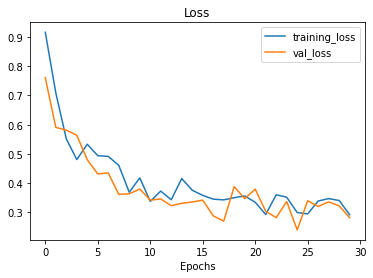

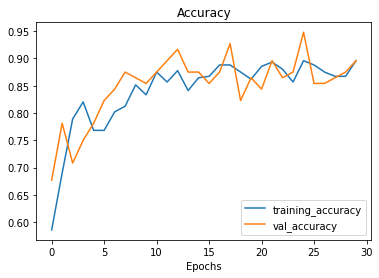

In [43]:
plot_loss_curves(history_5)

## Model 6 of 10 

Efficient Net B0 Fine Tuning

In [44]:
#1 Train data
train_data_6 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                      label_mode = "categorical",
                                                                      image_size = (224, 224))

test_data_6 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                     label_mode = "categorical",
                                                                     image_size = (224, 224))

Found 12121 files belonging to 3 classes.
Found 3032 files belonging to 3 classes.


In [45]:
#2. Make a base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = True

for layer in base_model.layers[:-15]:
  layer.trainable = False

In [46]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#3. Make an augmented layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2)
])

In [47]:
#4. Write the layers
inputs = layers.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation = "softmax")(x)

In [48]:
#5. Build the model
model_6 = tf.keras.Model(inputs, outputs)

In [49]:
#6. Compile the model
model_6.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [50]:
#7. Train the model
fine_tune_epochs = 40
history_6 = model_6.fit(train_data_6,
                        epochs = fine_tune_epochs,
                        steps_per_epoch = len(train_data_6) / 32,
                        validation_data = test_data_6,
                        validation_steps = len(test_data_6) / 32,
                        initial_epoch = history_5.epoch[-1])

Epoch 30/40
11/11 [==============================] - 52s 4s/step - loss: 0.9307 - accuracy: 0.5952 - val_loss: 0.6077 - val_accuracy: 0.7396
Epoch 31/40
11/11 [==============================] - 41s 4s/step - loss: 0.5136 - accuracy: 0.7922 - val_loss: 0.5915 - val_accuracy: 0.7500
Epoch 32/40
11/11 [==============================] - 41s 4s/step - loss: 0.5666 - accuracy: 0.7873 - val_loss: 0.5132 - val_accuracy: 0.7500
Epoch 33/40
11/11 [==============================] - 41s 4s/step - loss: 0.3979 - accuracy: 0.8511 - val_loss: 0.9399 - val_accuracy: 0.4896
Epoch 34/40
11/11 [==============================] - 39s 3s/step - loss: 0.4926 - accuracy: 0.7693 - val_loss: 0.3370 - val_accuracy: 0.8750
Epoch 35/40
11/11 [==============================] - 40s 3s/step - loss: 0.3003 - accuracy: 0.9096 - val_loss: 0.3780 - val_accuracy: 0.8438
Epoch 36/40
11/11 [==============================] - 40s 3s/step - loss: 0.3274 - accuracy: 0.8730 - val_loss: 0.2882 - val_accuracy: 0.9062
Epoch 37/40
1

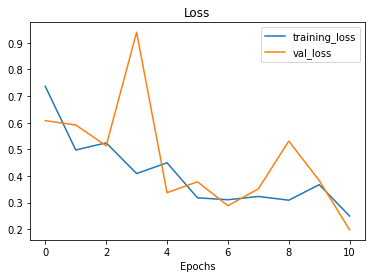

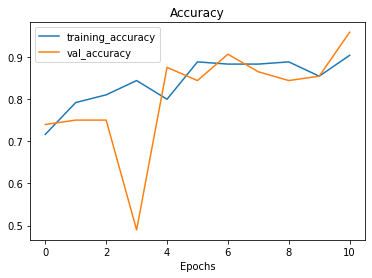

In [51]:
plot_loss_curves(history_6)

## Model 7 of 10

Efficient Net B4 FE with EarlyStopping

In [52]:
#1. Train data
train_data_7 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = (224, 224))

test_data_7 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = (224, 224))

Found 12121 files belonging to 3 classes.
Found 3032 files belonging to 3 classes.


In [53]:
#2. Import the base model
base_model = tf.keras.applications.EfficientNetB4(include_top = False)

base_model.trainable = False

71688192/71686520 [==============================] - 1s 0us/step


In [54]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#3. Write a data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2)
])

In [55]:
#4. Create the layers
inputs = layers.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation = "softmax")(x)

In [56]:
#5. Create the model
model_7 = tf.keras.Model(inputs, outputs)

In [57]:
#6. Compile the model
model_7.compile(loss = tf.keras.losses.categorical_crossentropy, 
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [58]:
#7. Fit the model
history_7 = model_7.fit(train_data_7,
                        epochs = 30,
                        steps_per_epoch = len(train_data_7) / 32,
                        validation_data = test_data_7,
                        validation_steps = len(test_data_7) / 32)

Epoch 1/30
11/11 [==============================] - 128s 10s/step - loss: 0.9124 - accuracy: 0.5646 - val_loss: 0.7932 - val_accuracy: 0.6979
Epoch 2/30
11/11 [==============================] - 99s 8s/step - loss: 0.6328 - accuracy: 0.7441 - val_loss: 0.6173 - val_accuracy: 0.7812
Epoch 3/30
11/11 [==============================] - 91s 8s/step - loss: 0.5529 - accuracy: 0.7907 - val_loss: 0.5782 - val_accuracy: 0.7604
Epoch 4/30
11/11 [==============================] - 97s 8s/step - loss: 0.5330 - accuracy: 0.7863 - val_loss: 0.4774 - val_accuracy: 0.8229
Epoch 5/30
11/11 [==============================] - 90s 8s/step - loss: 0.5138 - accuracy: 0.8142 - val_loss: 0.5012 - val_accuracy: 0.8125
Epoch 6/30
11/11 [==============================] - 94s 8s/step - loss: 0.4178 - accuracy: 0.8304 - val_loss: 0.3605 - val_accuracy: 0.8646
Epoch 7/30
11/11 [==============================] - 94s 8s/step - loss: 0.5008 - accuracy: 0.8076 - val_loss: 0.4149 - val_accuracy: 0.8542
Epoch 8/30
11/11 [

In [ ]:
plot_loss_curves(history_7)

## Model 8 of 10

Efficient Net B4 FT with EarlyStopping

In [59]:
#1. Train data
train_data_8 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = (224, 224))

test_data_8 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = (224, 224))

Found 12121 files belonging to 3 classes.
Found 3032 files belonging to 3 classes.


In [60]:
#2. Create a base model
base_model = tf.keras.applications.EfficientNetB4(include_top = False)

base_model.trainable = True

for layer in base_model.layers[:-15]:
  layer.trainable = False

In [61]:
#3. Create the layers
inputs = layers.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation = "softmax")(x)

In [62]:
#4. Create the model
model_8 = tf.keras.Model(inputs, outputs)

In [63]:
#5. Compile the model
model_8.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ["accuracy"])

In [64]:
#6. Create a callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
)

In [65]:
#7. Train the model
fine_tune_epochs = 40
history_8 = model_8.fit(train_data_8,
                        epochs = fine_tune_epochs,
                        steps_per_epoch = len(train_data_8) / 32,
                        validation_data = test_data_8,
                        validation_steps = len(test_data_8) / 32,
                        initial_epoch = history_7.epoch[-1],
                        callbacks = [early_stopping])

Epoch 30/40
11/11 [==============================] - 130s 10s/step - loss: 1.0810 - accuracy: 0.3450 - val_loss: 0.8577 - val_accuracy: 0.6875
Epoch 31/40
11/11 [==============================] - 111s 10s/step - loss: 0.8033 - accuracy: 0.7072 - val_loss: 0.7595 - val_accuracy: 0.7083
Epoch 32/40
11/11 [==============================] - 111s 10s/step - loss: 0.7143 - accuracy: 0.7491 - val_loss: 0.7028 - val_accuracy: 0.8021
Epoch 33/40
11/11 [==============================] - 107s 9s/step - loss: 0.5711 - accuracy: 0.8146 - val_loss: 0.6973 - val_accuracy: 0.7500
Epoch 34/40
11/11 [==============================] - 112s 10s/step - loss: 0.5794 - accuracy: 0.8086 - val_loss: 0.6552 - val_accuracy: 0.7708
Epoch 35/40
11/11 [==============================] - 107s 9s/step - loss: 0.5149 - accuracy: 0.7870 - val_loss: 0.5684 - val_accuracy: 0.8229
Epoch 36/40
11/11 [==============================] - 103s 9s/step - loss: 0.4158 - accuracy: 0.8715 - val_loss: 0.5851 - val_accuracy: 0.8125


In [ ]:
plot_loss_curves(history_8)

## Model 9 of 10

ResNet Feature Extraction

In [66]:
#1. Make a train data
train_data_9 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = (224, 224))

test_data_9 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = (224, 224))

Found 12121 files belonging to 3 classes.
Found 3032 files belonging to 3 classes.


In [67]:
#2. Import the base model
base_model = tf.keras.applications.ResNet50(include_top = False)

base_model.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [68]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#3. Create a data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
])

In [69]:
#4. Create model layers
inputs = layers.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation = "softmax")(x)

In [70]:
#5. Create the model
model_9 = tf.keras.Model(inputs, outputs)

In [71]:
#6. Compile the model
model_9.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [72]:
#7. Fit the model
history_9 = model_9.fit(train_data_9,
                        epochs = 30,
                        steps_per_epoch = len(train_data_9) / 32,
                        validation_data = test_data_9,
                        validation_steps = len(test_data_9) / 32)

Epoch 1/30
11/11 [==============================] - 109s 9s/step - loss: 0.9782 - accuracy: 0.5392 - val_loss: 0.5094 - val_accuracy: 0.8021
Epoch 2/30
11/11 [==============================] - 96s 8s/step - loss: 0.5925 - accuracy: 0.7391 - val_loss: 0.5921 - val_accuracy: 0.7188
Epoch 3/30
11/11 [==============================] - 87s 8s/step - loss: 0.5645 - accuracy: 0.7922 - val_loss: 0.6045 - val_accuracy: 0.8021
Epoch 4/30
11/11 [==============================] - 92s 8s/step - loss: 0.5288 - accuracy: 0.7718 - val_loss: 0.5350 - val_accuracy: 0.8021
Epoch 5/30
11/11 [==============================] - 96s 8s/step - loss: 0.4999 - accuracy: 0.7774 - val_loss: 0.4256 - val_accuracy: 0.8646
Epoch 6/30
11/11 [==============================] - 97s 8s/step - loss: 0.4727 - accuracy: 0.7857 - val_loss: 0.5089 - val_accuracy: 0.8021
Epoch 7/30
11/11 [==============================] - 95s 8s/step - loss: 0.4439 - accuracy: 0.8251 - val_loss: 0.5395 - val_accuracy: 0.8229
Epoch 8/30
11/11 [=

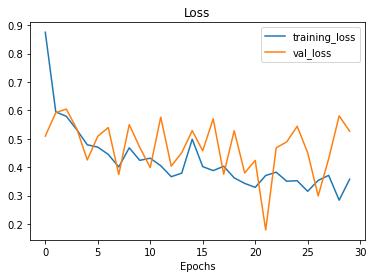

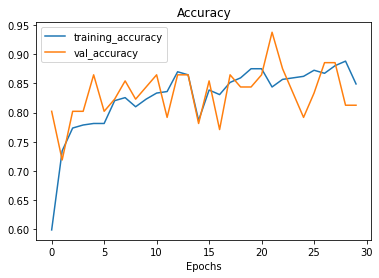

In [73]:
plot_loss_curves(history_9)

## Model 10 of 10

Resnet Fine Tuning

In [74]:
#1. Train data gen
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode = "categorical",
                                                                    image_size = (224, 224))

test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = (224, 224))

Found 12121 files belonging to 3 classes.
Found 3032 files belonging to 3 classes.


In [75]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#2. Create the data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
])

In [76]:
#3. Import the base model
base_model = tf.keras.applications.ResNet50(include_top = False)

base_model.trainable = True

for layer in base_model.layers[:-15]:
  layer.trainable = False

In [77]:
#4. Create the layers
inputs = layers.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation = "softmax")(x)

In [78]:
#5. Create the model
model_10 = tf.keras.Model(inputs, outputs)

In [79]:
#6. Compile the model
model_10.compile(loss = tf.keras.losses.categorical_crossentropy,
                 optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                 metrics = ["accuracy"])

In [80]:
#7. Fit the model
history_10 = model_10.fit(train_data_10,
                          epochs = fine_tune_epochs,
                          steps_per_epoch = len(train_data_10) / 32,
                          validation_data = test_data_10,
                          validation_steps = len(test_data_10) / 32,
                          initial_epoch = history_9.epoch[-1])

Epoch 30/40
11/11 [==============================] - 122s 10s/step - loss: 1.1530 - accuracy: 0.4391 - val_loss: 1.6739 - val_accuracy: 0.6562
Epoch 31/40
11/11 [==============================] - 112s 10s/step - loss: 0.5231 - accuracy: 0.8162 - val_loss: 2.2642 - val_accuracy: 0.6042
Epoch 32/40
11/11 [==============================] - 118s 10s/step - loss: 0.4655 - accuracy: 0.8306 - val_loss: 1.3301 - val_accuracy: 0.7500
Epoch 33/40
11/11 [==============================] - 107s 9s/step - loss: 0.3945 - accuracy: 0.8405 - val_loss: 1.3051 - val_accuracy: 0.6979
Epoch 34/40
11/11 [==============================] - 106s 9s/step - loss: 0.3854 - accuracy: 0.8388 - val_loss: 0.8995 - val_accuracy: 0.7604
Epoch 35/40
11/11 [==============================] - 105s 9s/step - loss: 0.3921 - accuracy: 0.8244 - val_loss: 1.0076 - val_accuracy: 0.7604
Epoch 36/40
11/11 [==============================] - 106s 9s/step - loss: 0.3216 - accuracy: 0.8853 - val_loss: 0.4572 - val_accuracy: 0.8438
Epo

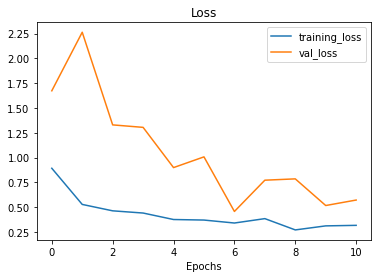

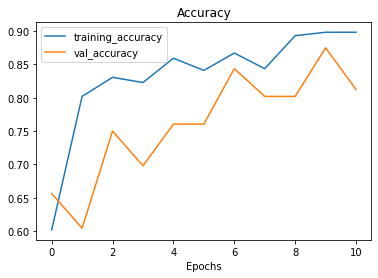

In [82]:
plot_loss_curves(history_10)

#Evaluate the Models

In [86]:
model_1_evaluation = model_1.evaluate(test_data)
model_1_evaluation

95/95 [==============================] - 61s 645ms/step - loss: 0.3633 - accuracy: 0.8536


[0.3632858097553253, 0.8535619974136353]

In [96]:
model_2_evaluation = model_2.evaluate(test_data_2)
model_2_evaluation

95/95 [==============================] - 117s 1s/step - loss: 0.4608 - accuracy: 0.7925


[0.460785835981369, 0.7925461530685425]

In [88]:
model_3_evaluation = model_3.evaluate(test_data_3)
model_3_evaluation

95/95 [==============================] - 143s 1s/step - loss: 0.4507 - accuracy: 0.7975


[0.4507484436035156, 0.7974933981895447]

In [89]:
model_4_evaluation = model_4.evaluate(test_data_4)
model_4_evaluation

95/95 [==============================] - 130s 1s/step - loss: 0.4994 - accuracy: 0.7820


[0.4993900954723358, 0.7819920778274536]

In [90]:
model_5_evaluation = model_5.evaluate(test_data_5)
model_5_evaluation

95/95 [==============================] - 211s 2s/step - loss: 0.3138 - accuracy: 0.8898


[0.3138044774532318, 0.8898416757583618]

In [91]:
model_6_evaluation = model_6.evaluate(test_data_6)
model_6_evaluation

95/95 [==============================] - 211s 2s/step - loss: 0.3057 - accuracy: 0.8872


[0.3056759536266327, 0.8872031569480896]

In [92]:
model_7_evaluation = model_7.evaluate(test_data_7)
model_7_evaluation

95/95 [==============================] - 566s 6s/step - loss: 0.3400 - accuracy: 0.8727


[0.3400476276874542, 0.87269127368927]

In [93]:
model_8_evaluation = model_8.evaluate(test_data_8)
model_8_evaluation

95/95 [==============================] - 571s 6s/step - loss: 0.5322 - accuracy: 0.8414


[0.5322295427322388, 0.8413588404655457]

In [94]:
model_9_evaluation = model_9.evaluate(test_data_9)
model_9_evaluation

95/95 [==============================] - 495s 5s/step - loss: 0.4414 - accuracy: 0.8542


[0.44137129187583923, 0.8542216420173645]

In [95]:
model_10_evaluation = model_10.evaluate(test_data_10)
model_10_evaluation

95/95 [==============================] - 493s 5s/step - loss: 0.3871 - accuracy: 0.8592


[0.38706257939338684, 0.8591688871383667]